In [1]:
import tensorflow as tf
import keras
from keras import layers, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.datasets import cifar10

1. Preparation and Inspection of the Data


In [2]:
def prep_cifar(train_data, test_data, batch_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 128) - 1  # Normalized
        label = tf.one_hot(label, depth=10)
        return img, label

    train_data = train_data.map(preprocessing_func).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_data = test_data.map(preprocessing_func).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_data, test_data


def get_familiar_with_data(dataset, name):
    for images, labels in dataset.take(1):
        print(f"{name} batch size:", images.shape[0])
        print("Each image size:", images.shape[1:])
        sample_labels = labels.numpy()
        print(f"Sample labels from {name} set:", sample_labels[:5] if sample_labels.ndim > 0 else sample_labels)

def visualize_data(dataset, num_images=9):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            img = ((images[i].numpy() + 1) * 128).astype("uint8")  # Denormalize
            plt.imshow(img)
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")

    plt.show()


In [3]:
# Load CIFAR10 dataset
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete6JPLM4/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete6JPLM4/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


cifar batch size: 64
Each image size: (32, 32, 3)
Sample labels from cifar set: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


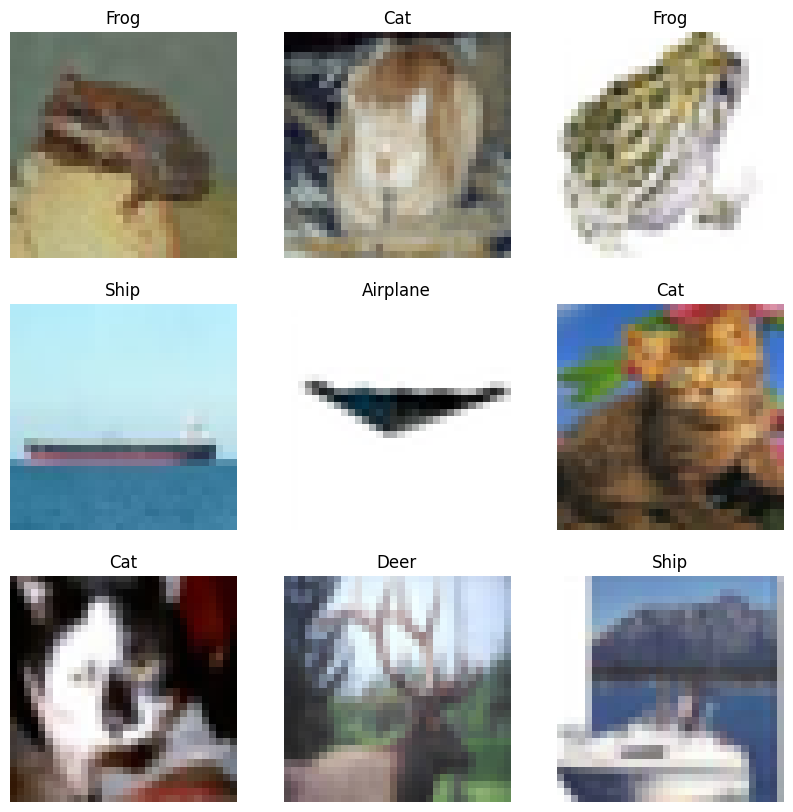

In [4]:
# Preprocess the data
batch_size = 64
shuffle_buffer_size = 10000

# Train the data
#train_data, test_data = prep_cifar(train_data, test_data, batch_size, shuffle_buffer_size)
train_data, test_data = prep_cifar(train_data, test_data, batch_size)

# Get familiar with the data
get_familiar_with_data(train_data, 'cifar')

# Visualize the data
visualize_data(train_data)


2. The CNN Model

In [6]:

class CNN():
    def __init__(self, input_size=(32, 32, 3), num_filters=[32, 64, 128], kernel_size=[(3,3), (3,3), (3,3)], strides=[(1,1), (1,1), (1,1)], conv_activation='relu', cnn_pool_type="max_pool",
                 padding="valid", use_bias=False, dense_activation='relu', dense_sizes=[256], num_classes=10, flatten_type="global_max", name="CNN_model"):

        self.input_size = input_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.conv_activation = conv_activation
        self.cnn_pool_type = cnn_pool_type
        self.padding = padding
        self.use_bias = use_bias
        self.dense_activation = dense_activation
        self.dense_sizes = dense_sizes
        self.num_classes = num_classes
        self.flatten_type = flatten_type
        self.name = name
        self.last_performance = {
            'train_loss_results': [],
            'train_accuracy_results': [],
            'test_loss': -1,
            'test_accuracy': -1,
        }

        self.model = None
        self.create_cnn()



    def create_cnn(self):
        inputs = layers.Input(shape=(self.input_size), dtype=tf.float32)
        x = inputs

        # Create CNN part with pooling layers
        for i, num_filter in enumerate(self.num_filters):
            x = layers.Conv2D(num_filter, self.kernel_size[i], self.strides[i], self.padding, activation=self.conv_activation, use_bias=self.use_bias)(x)
            x = layers.BatchNormalization()(x)
            if self.cnn_pool_type == "max_pool":
                x = layers.MaxPool2D()(x)
            else:
                x = layers.AveragePooling2D()(x)
            #x = layers.Dropout(0.2)(x)

        # Flatten the output of the CNN part for it to fit into the MLP part
        if self.flatten_type == "global_max":
            x = layers.GlobalMaxPool2D()(x)
        else:
            x = layers.GlobalAveragePooling2D()(x)

        # Create the MLP part
        for i, dense_size in enumerate(self.dense_sizes):
            x = layers.Dense(dense_size, activation=self.dense_activation)(x)

        # Create the output part
        y = layers.Dense(units=self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=y, name=self.name)
        self.model.summary()




    def train(self, train_data, test_data, epochs=15, learning_rate=0.01, optimizer='adam'):
        # Setup the optimizer
        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        loss_f = tf.keras.losses.CategoricalCrossentropy()

        self.last_performance['test_loss_results'] = []
        self.last_performance['test_accuracy_results'] = []

        # Training loop
        for epoch in range(epochs):
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
            for image, label in train_data:
                with tf.GradientTape() as tape:
                    pred = self.model(image)
                    loss = loss_f(label, pred)

                gradients = tape.gradient(loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                epoch_loss_avg.update_state(loss)
                epoch_accuracy.update_state(label, pred)

            self.last_performance['train_loss_results'].append(epoch_loss_avg.result())
            self.last_performance['train_accuracy_results'].append(epoch_accuracy.result())
            print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")

            test_loss, test_accuracy = self.evaluate(test_data)
            self.last_performance['test_loss_results'].append(test_loss)
            self.last_performance['test_accuracy_results'].append(test_accuracy)

            print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
            print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

        self.last_performance['test_loss'], self.last_performance['test_accuracy'] = self.evaluate(test_data)
        print(f"Test Loss: {self.last_performance['test_loss']}, Test Accuracy: {self.last_performance['test_accuracy']}")




    def evaluate(self, test_data):
        loss_f = tf.keras.losses.CategoricalCrossentropy()
        loss_list = []
        correct_predictions = 0
        total_samples = 0

        for image, label in test_data:
            pred = self.model(image)
            loss = loss_f(label, pred)
            loss_list.append(loss)

            # Fix: Compare the arrays element-wise
            correct_predictions += np.sum(np.argmax(label, axis=-1) == np.argmax(pred, axis=-1))
            total_samples += label.shape[0]

        # Calculate average loss and accuracy
        average_loss = np.mean(loss_list)
        accuracy = correct_predictions / total_samples
        return average_loss, accuracy

    def visualize_performance(self):
        epochs_range = range(1, len(self.last_performance['train_loss_results']) + 1)

        plt.figure(figsize=(14, 5))

        # Plot training and testing loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.last_performance['train_loss_results'], label='Training Loss')
        plt.plot(epochs_range, self.last_performance['test_loss_results'], label='Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Testing Loss')
        plt.legend()

        # Plot training and testing accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.last_performance['train_accuracy_results'], label='Training Accuracy')
        plt.plot(epochs_range, self.last_performance['test_accuracy_results'], label='Testing Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Testing Accuracy')
        plt.legend()

        plt.show()



        # Print and visualize test accuracy
        #print(f"Test accuracy: {self.last_performance['test_accuracy']}")
        #print(f"Test loss: {self.last_performance['test_loss']}")






In [ ]:
# Default Set of Hyperparameters for Testing Purposes
cnn_model = CNN()
cnn_model.train(train_data, test_data, epochs=3)
cnn_model.visualize_performance()


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        864       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)        25

In [ ]:
# Set 1:
set1_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(3,3), (3,3), (3,3)],
    strides=[(1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_1",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

batch_size_set1 = 32
train_data_set1, test_data_set1 = prep_cifar(train_data, test_data, batch_size_set1)

set1_model.train(train_data_set1, test_data_set1, epochs=3)

set1_model.visualize_performance()
